### Number of job apps

Couldn't determine result for: ['275', 'Medical Management Specialist', 'RN', 'LPC', 'LMSW', 'Innovative Systems Group', 'Springfield, IL', 'Hybrid', '2 days ago', '', '* 🥳 Applied!: https://www.linkedin.com/jobs/view/4172850063']
Successfully converted 2404 job entries to df


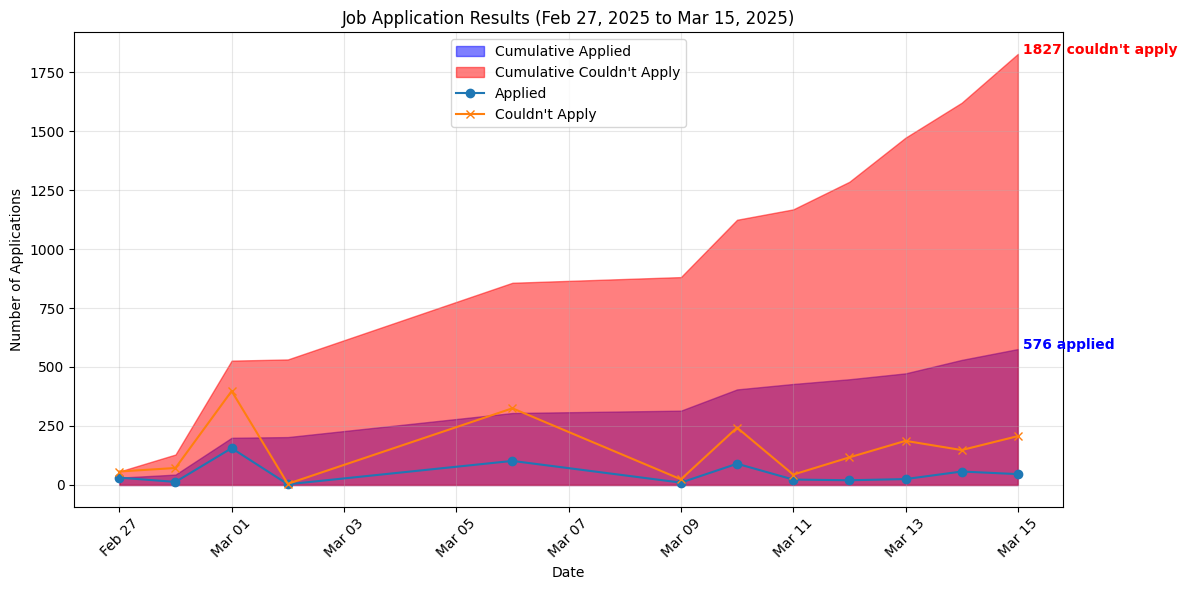

In [6]:
# convert data in data folder to df
import pandas as pd
import os
import matplotlib.pyplot as plt

data_files = [f for f in os.listdir('data') if f.startswith('Applied Jobs DATA')]
#data_files = ['Applied Jobs DATA - 20250301.txt']

# Initialize an empty list to store all job data
all_jobs = []

for file_name in data_files:
    file_path = os.path.join('data', file_name)
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        
        # Extract date from filename (format: 'Applied Jobs DATA - YYYYMMDD.txt')
        apply_date = None
        if ' - ' in file_name:
            date_str = file_name.split(' - ')[1].split('.')[0]
            if len(date_str) == 8:  # YYYYMMDD format
                apply_date = date_str
            
        # Skip header lines
        job_lines = [line.strip() for line in lines if '|' in line and not line.startswith('----')]
        
        for line in job_lines:
            if '|' in line:
                # Split the line by pipe character
                parts = [part.strip() for part in line.split('|')]
                
                # Check if this is a job entry (not a search result line)
                if len(parts) >= 7 and parts[0].isdigit():
                    # Extract basic job information
                    job_data = {
                        'Number': parts[0],
                        'Job_Title': parts[1],
                        'Company': parts[2],
                        'Location': parts[3],
                        'Work_Place': parts[4],
                        'Applications': parts[6],
                        'Apply_Date': apply_date
                    }
                    
                    # Determine application result - cleaning dirty data
                    result = ''
                    if 'Applied!' in parts[7] or 'Just Applied' in parts[7]:
                        result = 'applied'
                    elif 'Couldn\'t apply' in parts[7]:
                        result = 'couldn\'t apply'
                    elif len(parts) > 8:
                        if 'Applied!' in parts[8] or 'Just Applied' in parts[8]:
                            result = 'applied'
                        elif 'Couldn\'t apply' in parts[8]:
                            result = 'couldn\'t apply'
                    
                    job_data['Result'] = result
                    
                    # Extract job link - cleaning dirty data
                    link = ''
                    if 'https://' in parts[7]:
                        link = parts[7].split('https://')[1].split()[0]
                    elif len(parts) > 8 and 'https://' in parts[8]:
                        link = parts[8].split('https://')[1].split()[0]
                    
                    job_data['Link'] = link
                    
                    if job_data['Result'] == '':
                        print(f"Couldn't determine result for: {parts}")
                    
                    all_jobs.append(job_data)
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

# Convert to DataFrame
if all_jobs:
    df = pd.DataFrame(all_jobs)
    print(f"Successfully converted {len(all_jobs)} job entries to df")
else:
    print("No job data found to convert")

# Convert Apply_Date to datetime for better plotting
df['Apply_Date'] = pd.to_datetime(df['Apply_Date'], format='%Y%m%d')

# Group by date and count results
result_counts = df.groupby(['Apply_Date', 'Result']).size().unstack(fill_value=0)

# If columns are missing, add them with zeros
if 'applied' not in result_counts.columns:
    result_counts['applied'] = 0
if "couldn't apply" not in result_counts.columns:
    result_counts["couldn't apply"] = 0

# Calculate cumulative counts
cumulative_counts = result_counts.cumsum()

# Get date range for title
start_date = df['Apply_Date'].min().strftime('%b %d, %Y')
end_date = df['Apply_Date'].max().strftime('%b %d, %Y')

# Create the plot
plt.figure(figsize=(12, 6))
# Plot cumulative results in background with alpha=0.5
plt.fill_between(cumulative_counts.index, cumulative_counts['applied'], alpha=0.5, color='blue', label='Cumulative Applied')
plt.fill_between(cumulative_counts.index, cumulative_counts["couldn't apply"], alpha=0.5, color='red', label="Cumulative Couldn't Apply")
# Plot daily counts
plt.plot(result_counts.index, result_counts['applied'], marker='o', label='Applied')
plt.plot(result_counts.index, result_counts["couldn't apply"], marker='x', label="Couldn't Apply")

# Add cumulative totals as text at the end of the plot
last_date = cumulative_counts.index[-1]
applied_total = cumulative_counts['applied'].iloc[-1]
couldnt_total = cumulative_counts["couldn't apply"].iloc[-1]

plt.text(last_date, applied_total, f" {applied_total} applied", color='blue', fontweight='bold')
plt.text(last_date, couldnt_total, f" {couldnt_total} couldn't apply", color='red', fontweight='bold')

plt.title(f'Job Application Results ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Number of Applications')
plt.legend(loc='upper center')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
# Format x-axis date labels as 'Jan 1', 'Feb 27', etc.
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
plt.tight_layout()
plt.show()



### Job locations

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point
import us  # Python library for US state metadata

# Filter for only applied jobs
applied_jobs = df[df['Result'] == 'applied'].copy()

# Extract city and state from location
def extract_city_state(location):
    if pd.isna(location) or location == '':
        return None, None
    
    parts = location.split(',')
    if len(parts) >= 2:
        city = parts[0].strip()
        state = parts[1].strip()
        return city, state
    return location, None

# Apply extraction
applied_jobs[['City', 'State']] = applied_jobs['Location'].apply(
    lambda x: pd.Series(extract_city_state(x))
)

# Create state abbreviation to full name mapping using the 'us' library
state_abbrev = {state.abbr: state.name for state in us.states.STATES}

# Count applications by state
state_counts = applied_jobs['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

# Create a dataframe for the map
map_data = []
for state_abbr, count in applied_jobs['State'].value_counts().items():
    if state_abbr in state_abbrev:
        state_name = state_abbrev[state_abbr]
        map_data.append({
            'State': state_name,
            'StateAbbr': state_abbr,
            'Count': count,
            'Hover': f"{state_name} ({state_abbr}): {count} applications"
        })

map_df = pd.DataFrame(map_data)

# Create interactive map with Plotly
fig = px.choropleth(
    map_df,
    locations='StateAbbr',
    locationmode='USA-states',
    color='Count',
    scope='usa',
    color_continuous_scale='Reds',
    hover_name='Hover',
    title='Job Applications by State (Continental US)'
)

# Customize layout
fig.update_layout(
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    ),
    margin={"r":0,"t":40,"l":0,"b":0}
)

# Display the map
fig.show()

# Print summary statistics
print(f"Total applied jobs: {len(applied_jobs)}")

non_us_applications = applied_jobs[~applied_jobs['State'].isin(state_abbrev.keys())][['Company', 'Location']].drop_duplicates()

# Count applications inside and outside the US
us_applications = applied_jobs[applied_jobs['State'].isin(state_abbrev.keys())]
print(f"Applications in the US: {len(us_applications)}")
print(f"Applications 'outside' the US: {len(non_us_applications)}")

# # Display list of applications outside the US in a nicely formatted table
# print("Applications I could not categorize in a United State:")
# display(non_us_applications.style.set_properties(**{'text-align': 'left'})
#        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}]))


Total applied jobs: 576
Applications in the US: 402
Applications 'outside' the US: 140
